In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df1 =  pd.read_csv("steps.csv", sep= ";")
df2 = pd.read_csv("survey.csv")
df2 = df2.dropna(subset = ["weight", "height"])

We gooien alle mensen die minder dan 7x de fitbit hebben gebruikt eruit, zo weten we zeker dat de mensen hem niet een paar keer hebben gedragen en zo de boel manupileren.
ook zorgen we ervoor dat  al die stomme stappen niet meer in de dataset hebben. 

In [140]:
df1["fitbit_gebruikt"] = df1.iloc[:,1:].count(axis = 1)
df1 = df1[df1["fitbit_gebruikt"] > 7]
df1["mean_steps"] = df1.iloc[:,1:].mean(axis = 1, skipna= True)
df1 = df1.dropna(axis = 1, how = "any")

In [141]:
df = df2.merge(df1, on='id')
df = df[(df['weight'] < 200) & (df['weight'] > 35) & (df["mean_steps"] <30000)]
df.head()

,id,city,gender,age,hh_size,education,education_1,height,weight,fitbit_gebruikt,mean_steps
0,1,Bordeaux,Male,25-34,4,4,Master or doctorate,178.0,98.0,165,10145.036145
1,2,Lille,Male,35-44,1,3,Bachelor,180.0,77.0,163,5653.737805
2,3,Montpellier,Male,25-34,2,2,Master or doctorate,180.0,83.0,148,8247.006711
3,4,Lyon,Male,<25,1,1,Bachelor,178.0,80.0,20,3461.142857
4,5,Montpellier,Female,25-34,3,4,Bachelor,167.0,61.0,54,5216.527273


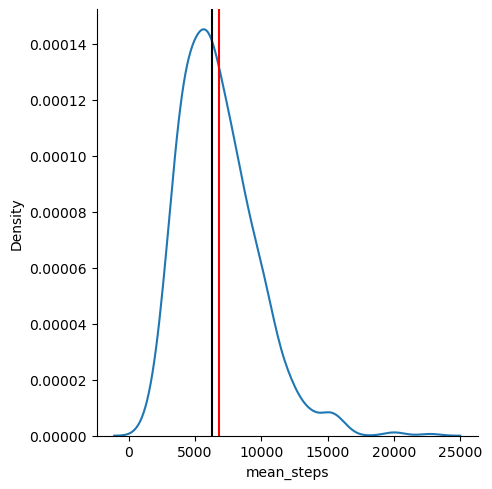

In [142]:
sns.displot(data = df, x = "mean_steps", kind = "kde")
plt.axvline(x= df.mean_steps.mean(), color= "red")
plt.axvline(x= df.mean_steps.median(), color= "black")
plt.show()

Zoals je ziet, zie je dat het niet de meest duidelijke grafiek is. Wat opvalt is dat de mediaan en het gemiddelde rechts van de piek zitten. Dit is logisch aangezien we een paar hele fanatiekelingen in deze grafiek hebben zitten! Deze mensen halen het gemiddelde flink omhoog. 

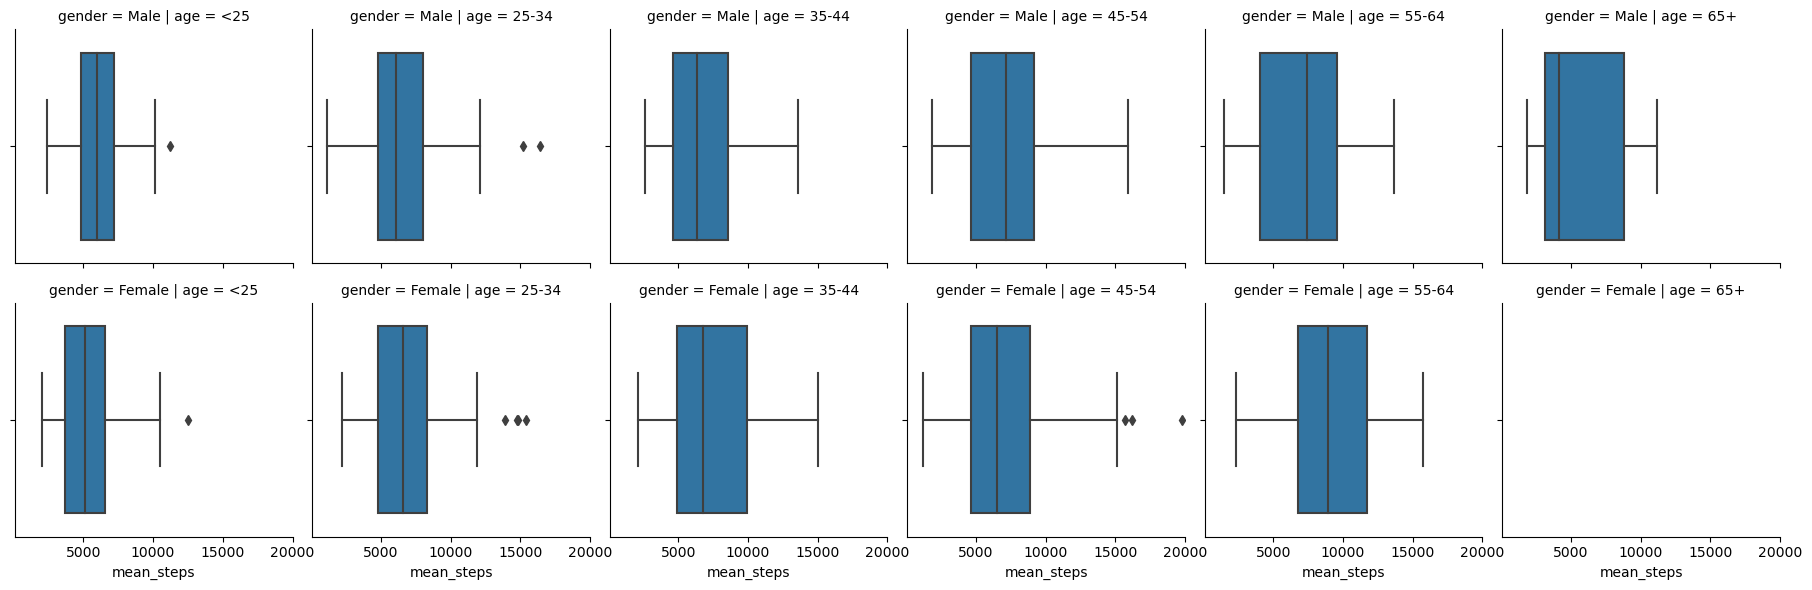

In [143]:
volgorde = ["<25", "25-34", "35-44", "45-54", "55-64", "65+"] 
g = sns.FacetGrid(data = df, col="age" , col_order= volgorde ,row = "gender")
g.map_dataframe(sns.boxplot, x= "mean_steps")
plt.xlim(right=20000)
plt.show()

Ik weet niet precies of dit de bedoeling was, maar als de doelstelling was om zoveel mogelijk grafieken te maken, is het me goed gelukt. Ik heb een xlim op de grafieken gegooid, aangezien je anders door de outliers niet goed de grafieken meer kon aflezen. Ook heb ik ze ff logisch op volgorde gezet.

Maar wat zie je nu? Ten eerste hebben geen vrouwen van 65+ meegedaan. Verder zie je dat hoe ouder de mensen worden, hoe verder de quatielen uitmekaar staan. Dit kan te maken hebben met het feit dat hier minder mensen van mee deden óf dat er onder oudere mensen grotere verschillen zijn tussen hoe actief ze zijn.

Verder valt het me op dat de medianen bij jongere leeftijden rond de 6000 hangt, maar dat bij oudere leeftijden het hoger uitvalt. zo rond de 9000. Dit hoeft nog niet te betekenen dat alle oude mensen meer bewegen dan jongeren. Eerder dat oudere mensen die gadgets kopen / gebruiken meditianiargezien (is dat een woord?) meer bewegen dan jongeren. 

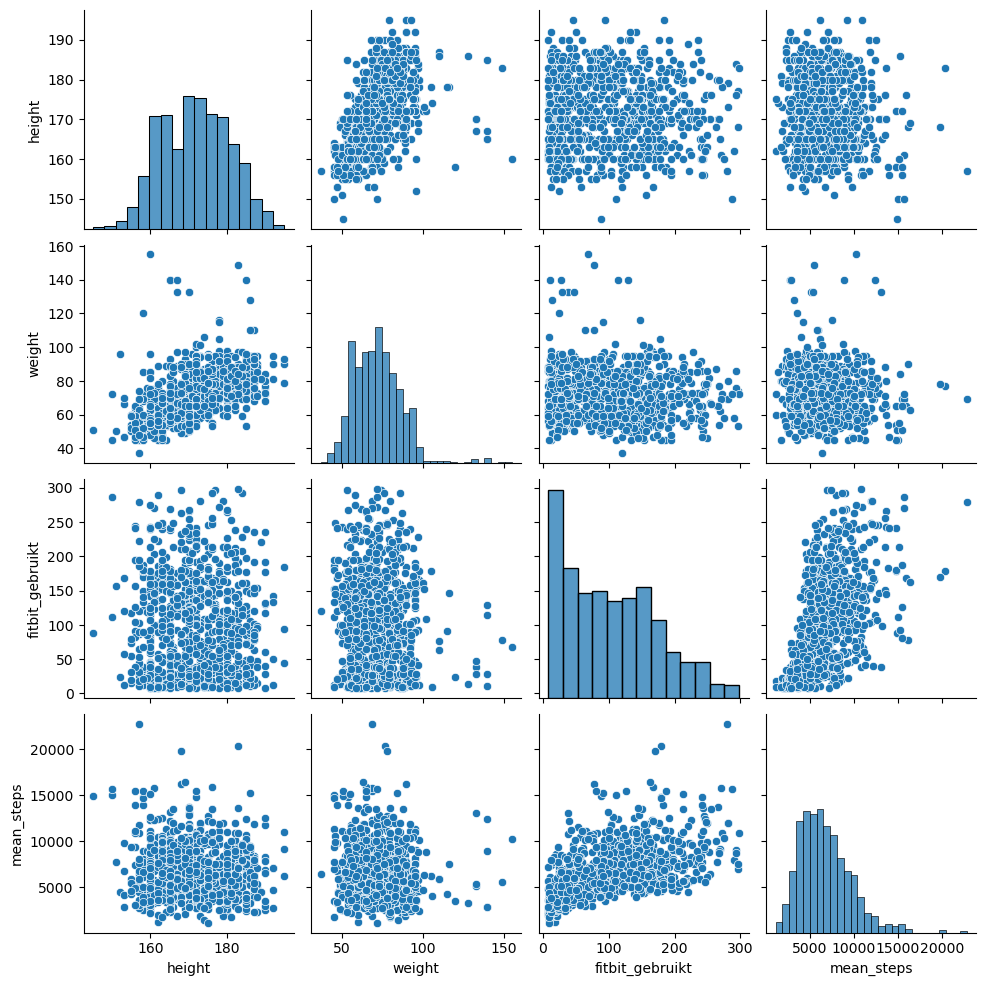

In [144]:
sns.pairplot(data= df, vars = ["height", "weight", "fitbit_gebruikt", "mean_steps"])
plt.show()

In [145]:
df_gender = pd.get_dummies(df.gender).drop(columns=["Male"]).rename(columns={"Female": "female"})
df = pd.concat([df,df_gender], axis = "columns")

In [146]:
df["age_n"] = df["age"].replace(["<25", "25-34", "35-44", "45-54", "55-64", "65+"], [0,1,2,3,4,5])

In [147]:
df_corr = df[["height", "weight", "fitbit_gebruikt", "mean_steps", "education", "female", "age_n"]].corr()
df_corr

,height,weight,fitbit_gebruikt,mean_steps,education,female,age_n
height,1.000000,0.507024,-0.022275,-0.072781,-0.027562,-0.710511,-0.091859
weight,0.507024,1.000000,-0.068533,-0.068132,0.018762,-0.422248,0.034718
fitbit_gebruikt,-0.022275,-0.068533,1.000000,0.568808,-0.003570,0.017535,0.099839
mean_steps,-0.072781,-0.068132,0.568808,1.000000,0.005235,0.057991,0.177481
education,-0.027562,0.018762,-0.003570,0.005235,1.000000,-0.000688,0.103084
female,-0.710511,-0.422248,0.017535,0.057991,-0.000688,1.000000,0.049620
age_n,-0.091859,0.034718,0.099839,0.177481,0.103084,0.049620,1.000000


Wat valt op? er zijn geen correlaties tussen hoe lang en zwaar mensen zijn tegenover hoeveel stappen ze zetten en hoevaak ze de fitbit hebben gebruikt. 
Voor de rest zijn er wel correlaties, maar die zijn niet héél sterk.

lineare regressie is een machine learning model die probeert om een (linear) model te maken dat data kan voorspellen in de dataset.     

In [148]:
from sklearn.linear_model import LinearRegression #we need this specific model from sk-learn
from sklearn.metrics import r2_score #we need this function from sklearn
import itertools
df_r2 = pd.DataFrame
best_combi = 0
best_r2 = 0
#To use sk-learn, we need to create lists of the two variables
#Note that you need to use [[ ]] with x. This creates a Pandas Data Frame (table), rather than a Pandas Series (list).
#lm.fit needs a Data Frame (or matrix) for x, because x can be multiple variables
stuff = ["education", "height", 'weight', 'fitbit_gebruikt', "female", "age_n", "id", "hh_size"]
for L in range(len(stuff) + 1):
  for subset in itertools.combinations(stuff, L):
    combi = list(subset)
    if len(combi) != 0:
      x = df[combi]
      y = df['mean_steps']
      lm = LinearRegression() #this creates a new LR model
      lm = lm.fit(x, y) #this "fits" the model
      df['mean_steps_p'] = lm.predict(x) #use built-in predict() method to generate predictions; store in original dataframe
      r2 = r2_score(df['mean_steps'], df['mean_steps_p'])
      if r2 > best_r2 :
        best_r2 =  r2
        best_combi = combi     

Dit hierboven is mede mogelijk gemaakt door Erik <3

Ik wilde eerst alles in een dataframe stoppen, om daarna dat te sorteren wat de hoogste waarde was, maar dit lukte me helaas niet :( Daarom maar deze manier gedaan, aangezien er meerdere wegen naar Rome lijden. 

Hoe had ik dit wel voor mekaar kunnen krijgen? Ik had dit geprobeerd:

df_r2["combi'] = combi

df_r2["r2"] = r2

In [149]:
from sklearn.linear_model import LinearRegression
x = df[best_combi]
y = df["mean_steps"]
lm = LinearRegression()
lm = lm.fit(x,y)


from sklearn.metrics import r2_score
df["mean_steps_p"] = lm.predict(x)
r2_score(df["mean_steps"], df["mean_steps_p"])

0.34327714832458567

In [150]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(df["mean_steps"], df["mean_steps_p"]))

2354.0129439015077

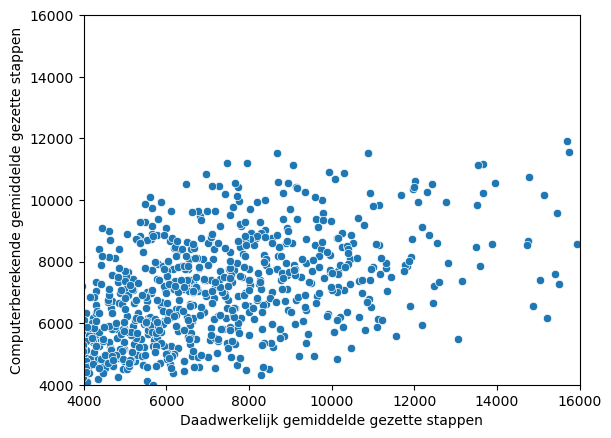

In [151]:
sns.scatterplot(data=df, x="mean_steps", y="mean_steps_p")
plt.xlabel("Daadwerkelijk gemiddelde gezette stappen")
plt.ylabel("Computerberekende gemiddelde gezette stappen")
plt.xlim(4000,16000)
plt.ylim(4000,16000)
#plt.plot([4000,16000],[4000,1600], color= "red", lw=3) ik weet niet hoe je deze goed kreeg :(
plt.show()

Wat opvalt is dat de berekening niet heel geweldig is. Wanneer de gebruiker daadwerkelijk weinig stappen heeft gezet, dan zou de computer voor de desbetreffende persoon denken dat die meer stappen zou hebben gezet. Terwijl mensen die veel stappen hebben gezet, door het algoritme zou worden ingeschat dat die weinig stappen zou hebben gezet.

Er zitten zo goed als geen correlaties in deze dataset die helpen met het bepalen van de gemiddelde gezette stappen. 

Conclusie:

Ik heb, ondanks dat deze dataset niet veel correlaties heeft te bieden, veel geleerd. Ik weet hoe ik datasets moet opschonen en samenvoegen. Ik heb mezelf extra uitgedaagd bij het maken van deze opdracht. van Variable ==> numeriek krijgen. Ook heb ik geleerd hoe je voorspellingen kan maken. 